#Run Every Session (Collapse and run it all at once, only once after connecting. No need to run it every time)

##Importing the Libraries

In [ ]:
import sklearn
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from datetime import timedelta
import random

##Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


##Compiling all Utility Functions

In [ ]:
def prepare_time_schedule(annotations_sheet, before_mins, after_mins):
  annotations = pd.read_csv(annotations_sheet)
  annotations['timestamp_start'] = pd.to_datetime(annotations['timestamp_start'], format='mixed')
  annotations['timestamp_end'] = pd.to_datetime(annotations['timestamp_end'], format='mixed')

  time_schedule_dict={
    'iteration no.':[],
    'phase':[],
    'timestamp':[]
  }

  for i in annotations['iteration_no.'].values.tolist():
    filtered_ds = annotations[annotations['iteration_no.']==i]
    before_start = filtered_ds['timestamp_start'].iloc[0]+timedelta(minutes=0-before_mins)
    after_end = filtered_ds['timestamp_end'].iloc[0]+timedelta(minutes=after_mins)

    time_schedule_dict['iteration no.'].append(i)
    time_schedule_dict['phase'].append('before')
    time_schedule_dict['timestamp'].append(before_start)

    time_schedule_dict['iteration no.'].append(i)
    time_schedule_dict['phase'].append('during')
    time_schedule_dict['timestamp'].append(filtered_ds['timestamp_start'].iloc[0])

    time_schedule_dict['iteration no.'].append(i)
    time_schedule_dict['phase'].append('after')
    time_schedule_dict['timestamp'].append(filtered_ds['timestamp_end'].iloc[0])

    time_schedule_dict['iteration no.'].append(i)
    time_schedule_dict['phase'].append(np.nan)
    time_schedule_dict['timestamp'].append(after_end)

  return pd.DataFrame(time_schedule_dict)

In [ ]:
def preprocess_dataset(df_agg_2, time_schedule_dict):
  df_agg_2=df_agg_2.sort_values(by='timestamp')
  df_agg_2['timestamp'] = pd.to_datetime(df_agg_2['timestamp'])
  def set_iteration(x):
    try:
      return time_schedule_dict[time_schedule_dict['timestamp']<=x].iloc[-1]['iteration no.']
    except:
      return np.nan

  def set_phase(x):
    try:
      return time_schedule_dict[time_schedule_dict['timestamp']<=x].iloc[-1]['phase']
    except:
      return np.nan

  df_agg_2['iteration no.'] = df_agg_2['timestamp'].apply(lambda x: set_iteration(x))
  df_agg_2['phase'] = df_agg_2['timestamp'].apply(lambda x: set_phase(x))
  df_agg_2 = df_agg_2.dropna()
  df_agg_2["seconds_elapsed"] = df_agg_2.groupby("iteration no.")["timestamp"].transform(lambda x: (x - x.min()).dt.total_seconds())

  return df_agg_2

In [ ]:
#plotting the activity
def generate_and_save_graph(dataframe, graph_pdf_destination, activity_name, before_mins, after_mins, clean = False, scale=False):
  #Removing all outliers using IQR method
  #dataframe = pd.read_csv(dataframe_path)
  # List of valid markers
  valid_markers = ["o","D","H"]
  # List of valid linestyles
  valid_linestyles = list(mlines.Line2D.lineStyles.keys())[:4]
  if clean:
    dataframe_clean = dataframe[(dataframe['pm1']>=dataframe['pm1'].quantile(0.25)) & (dataframe['pm1']<=dataframe['pm1'].quantile(0.75)) &
            (dataframe['pm2_5']>=dataframe['pm2_5'].quantile(0.25)) & (dataframe['pm2_5']<=dataframe['pm2_5'].quantile(0.75)) &
            (dataframe['pm10']>=dataframe['pm10'].quantile(0.25)) & (dataframe['pm10']<=dataframe['pm10'].quantile(0.75))]
  else:
    dataframe_clean = dataframe
  plt.figure(figsize=(10,30))
  pollutants = ['pm2_5','co','co2','voc','temperature','humidity']
  fig_no = 1
  for p in pollutants:
    plt.subplot(len(pollutants),1,fig_no)
    fig_no += 1
    for i in dataframe_clean["iteration no."].unique():
      dataframe_filtered = dataframe_clean[dataframe_clean["iteration no."]==i]
      if scale==True:
        plt.plot(dataframe_filtered["seconds_elapsed"], MinMaxScaler().fit_transform(np.reshape(np.array(dataframe_filtered[p]),(-1,1))),marker = valid_markers[int(random.uniform(0,len(valid_markers)-1))], linestyle = valid_linestyles[int(random.uniform(0,len(valid_linestyles)-1))], markevery=3, label=f"Iteration {int(i)}",mfc="black")
      else:
        plt.plot(dataframe_filtered["seconds_elapsed"], dataframe_filtered[p],marker = valid_markers[int(random.uniform(0,len(valid_markers)-1))], linestyle = valid_linestyles[int(random.uniform(0,len(valid_linestyles)-1))], markevery=3, label=f"Iteration {int(i)}",mfc="black")
    plt.title(f"{p}")
    plt.axvspan(0,int(60*before_mins),color='yellow',alpha=0.2, label = "Before")
    plt.axvspan(int(60*before_mins),int(60*(10+before_mins)),color='green',alpha=0.2, label = "During")
    plt.axvspan(int(60*(before_mins+10)),int(60*(before_mins+10+after_mins)),color='red',alpha=0.2, label = "After")
    plt.legend()
    plt.xlabel("Seconds Elapsed")
    plt.ylabel("Normalised Concentration (Scale of 0-1)")
    plt.grid(True)
  plt.suptitle(activity_name, y=0.92, fontsize=20)
  plt.savefig(graph_pdf_destination,bbox_inches='tight')
  plt.show()

In [ ]:
def filter_data_and_create_graph(dataset, strategy, window_length, graph_title, graph_save_path, before_mins, after_mins, savgol_filter_poly=1, scale=False):
  from scipy.signal import savgol_filter
  if strategy == "savgol":
    def my_filter(x):
        return savgol_filter(x, window_length, savgol_filter_poly)
  df_iterwise=[]
  comfort_factors = ['pm2_5','co','voc','co2','temperature','humidity']
  for iter in dataset['iteration no.'].unique():
    dummy_series = dataset[dataset['iteration no.']==iter].sort_values(by='timestamp')
    if strategy=="mov_avg":
      for factor in comfort_factors:
        dummy_series[factor] = dummy_series[factor].rolling(window=window_length).mean()
    elif strategy=="savgol":
      dummy_series[comfort_factors+['seconds_elapsed']] =  dummy_series[comfort_factors+['seconds_elapsed']].apply(my_filter)
    else:
      print("Invalid Filter. Filter should be either 'mov_avg' or 'savgol'")
      return
    df_iterwise.append(dummy_series)
  filtered_ds = pd.concat(df_iterwise).dropna()
  generate_and_save_graph(filtered_ds,graph_save_path,graph_title,before_mins, after_mins, clean=False, scale=scale)
  return filtered_ds

In [ ]:
def runprogram(preprocessed_ds, preprocessed_data_destination, filtered_data_destination, before_mins, after_mins, filtering_strategy, window_length, graph_title, graph_save_path, savgol_filter_poly, scale):
  preprocessed_ds.to_csv(preprocessed_data_destination)
  if filtered_graph:
    filter_data_and_create_graph(preprocessed_ds, #The dataframe should contain these AT LEAST columns MANDATORILY: ['pm2_5','co','voc','co2','iteration no.','timestamp','seconds_elapsed']
                              strategy=filtering_strategy, #Strategy is either mov_avg for moving averages or savgol for savitzky golay filter
                              window_length=window_length,#Window length. Higher value = more smoothing = more data loss
                              graph_title=graph_title,
                              graph_save_path=graph_save_path,
                              savgol_filter_poly = savgol_filter_poly, #Used to tune the savgol filter polynomial degree. Should be strictly less than window size
                              scale = scale,
                              before_mins = before_mins,
                              after_mins = after_mins
                              ).to_csv(filtered_data_destination)
  else:
    generate_and_save_graph(preprocessed_ds, graph_save_path, graph_title, before_mins, after_mins, clean = False, scale=scale)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#RUN THE PROGRAM HERE

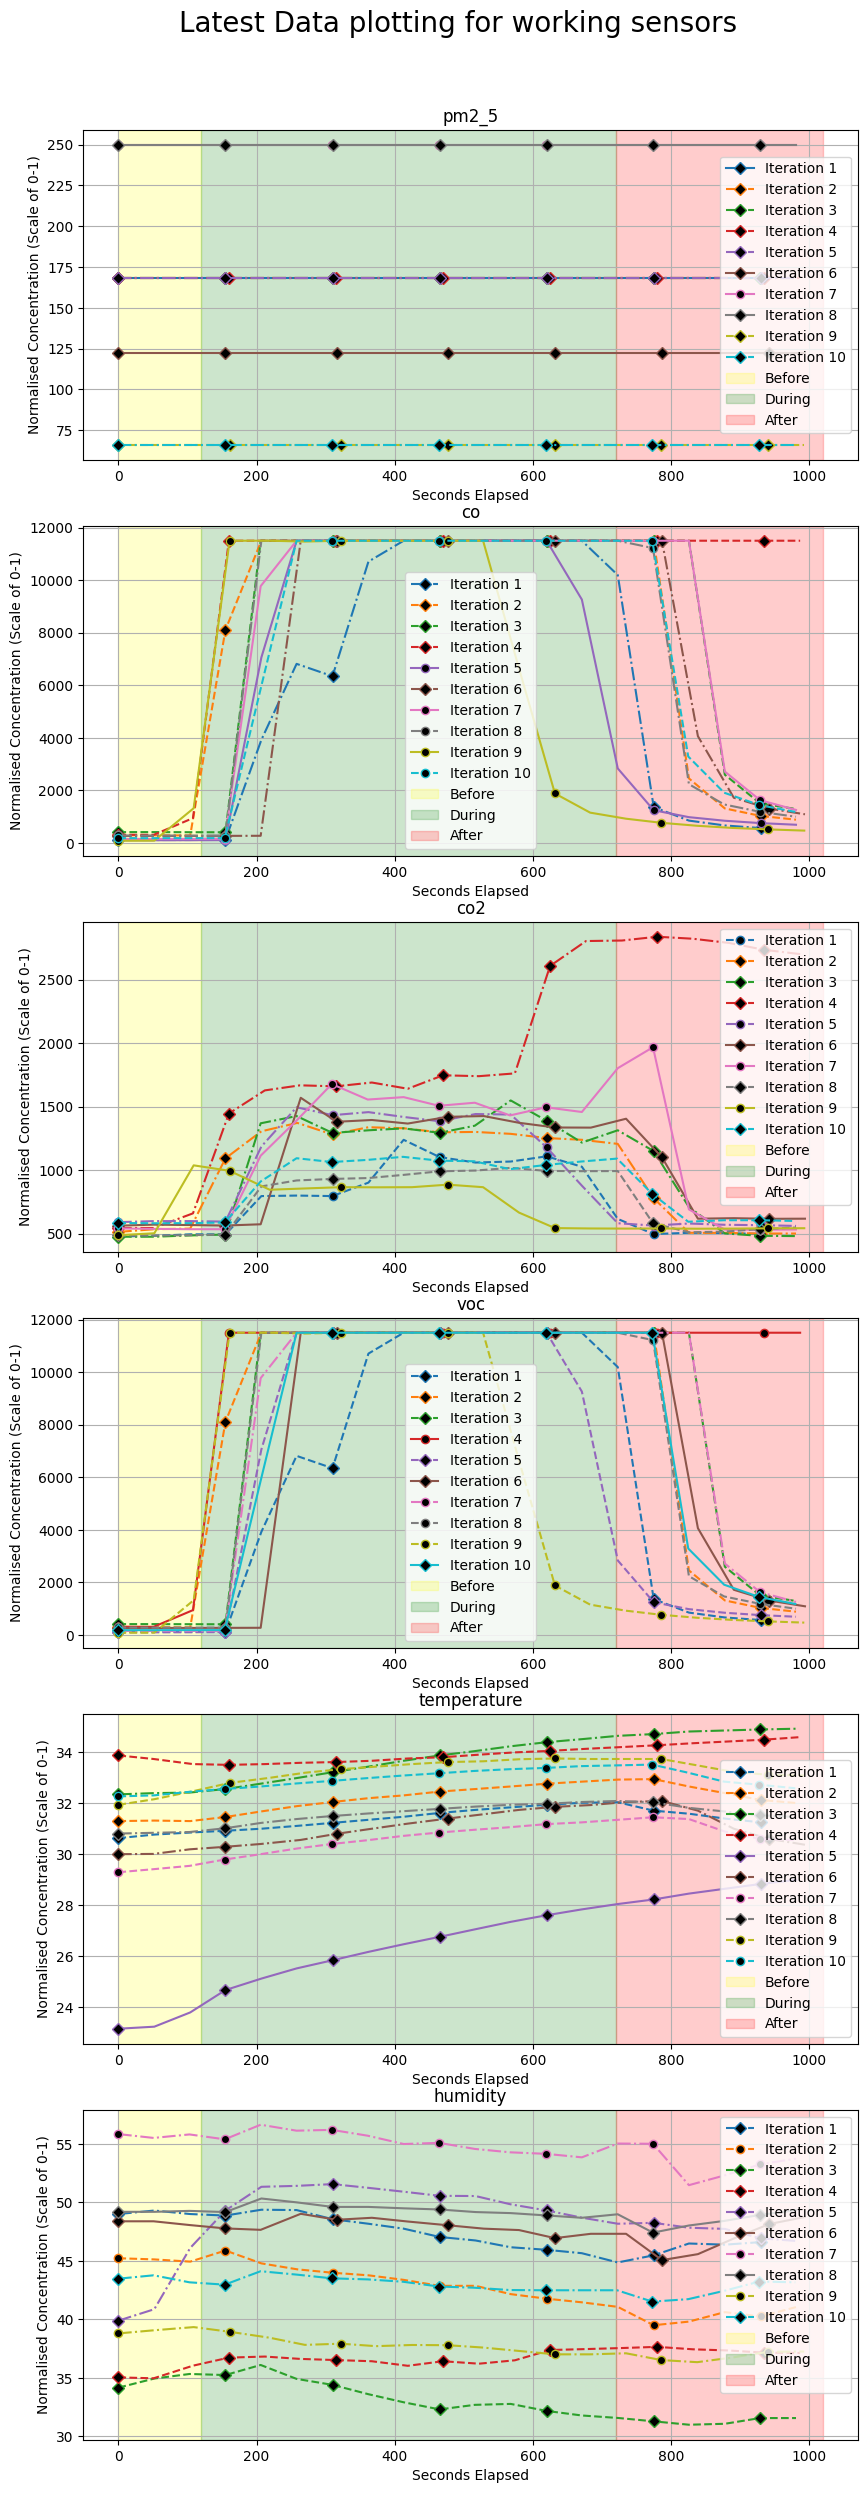

In [ ]:
# @title <h1>User Specifications (Only Change these factors and press RUN)</h1>
file_path = "/content/drive/MyDrive/Agg New/7_from_11_03_2025_to_00_00_00_12_03_2025_23_59_59.csv" # @param {"type":"string","placeholder":"File Path (Upload files downloaded from ipollusense_csv_maker_tool.py ONLY!!)"}
annotations_file_name = "/content/drive/MyDrive/Agg New/AggAnnotNew.csv" # @param {"type":"string","placeholder":"Annotations File Name (Follow the format discussed!!)"}
preprocessed_data_destination = "_.csv" # @param {"type":"string","placeholder":"Preprocessed Data Destination"}
filtered_data_destination = "_.csv" # @param {"type":"string","placeholder":"Filtered Data Destination"}
before_mins = 2 # @param {type:"integer"}
after_mins = 5 # @param {type:"integer"}

#@markdown Graph Configs
filtered_graph = False # @param {type:"boolean"}
graph_title = "Latest Data plotting for working sensors" # @param {"type":"string","placeholder":"Graph Title"}
graph_save_path = "_.pdf" # @param {"type":"string","placeholder":"Graph Save Path"}
scale = False # @param {type:"boolean"}

#@markdown Filter Configs
filtering_strategy = "Moving Average" # @param ["Moving Average","Savitzky Golay"]
window_length = 5 # @param {type:"integer"}
savgol_filter_poly = 3 # @param {type:"integer"}

filtering_strategy_map = {"Moving Average":"mov_avg",
                          "Savitzky Golay":"savgol"}
filtering_strategy = filtering_strategy_map[filtering_strategy]

#DON'T CHANGE ANY CODE, JUST RUN THIS CELL
runprogram(preprocess_dataset(pd.read_csv(file_path), prepare_time_schedule(annotations_file_name, before_mins, after_mins)), preprocessed_data_destination, filtered_data_destination, before_mins, after_mins, filtering_strategy, window_length, graph_title, graph_save_path, savgol_filter_poly, scale)